In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os 
import zipfile

In [5]:
# Make a directory to store the data
os.makedirs("Dataset")

In [6]:
with zipfile.ZipFile("/content/drive/MyDrive/covid-dataset/processed-data.zip", "r") as z_fp:
    z_fp.extractall("./Dataset/")

In [7]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(), #data augmentation
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [8]:
#Dataloader

#Path for training and validation directory
train_path='/content/Dataset/processed-data/train'
validation_path='/content/Dataset/processed-data/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=1, shuffle=True
)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=1, shuffle=True
)

In [9]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [10]:
print(classes)

['1NonCOVID', '2COVID']


In [11]:
#CNN Network
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Input shape= (256,3,256,256)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,256,256)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,256,256)
        self.relu1=nn.ReLU()
        #Shape= (256,12,256,256)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,128,128)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,128,128)
        self.relu2=nn.ReLU()
        #Shape= (256,20,128,128)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,128,128)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,128,128)
        self.relu3=nn.ReLU()
        #Shape= (256,32,128,128)
        
        
        self.fc=nn.Linear(in_features=128 * 128 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,128,128)
            
        output=output.view(-1,32*128*128)
            
            
        output=self.fc(output)
            
        return output

In [12]:
model=ConvNet(num_classes=6).to(device)

In [13]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [14]:
num_epochs=10

In [15]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))

In [16]:
print(train_count,validation_count)

11028 2758


In [22]:
#Model training and saving best model
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on validation dataset
    model.eval()
    
    validation_accuracy=0.0
    for i, (images,labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        validation_accuracy+=int(torch.sum(prediction==labels.data))
    
    validation_accuracy=validation_accuracy/validation_count

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Validation Accuracy: '+str(validation_accuracy))
    
    #Save the best model
    if validation_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=validation_accuracy


Epoch: 0 Train Loss: tensor(0.1995) Train Accuracy: 0.9383387740297425 Validation Accuracy: 0.90572878897752
Epoch: 1 Train Loss: tensor(0.1326) Train Accuracy: 0.9526659412404788 Validation Accuracy: 0.9158810732414794
Epoch: 2 Train Loss: tensor(0.1017) Train Accuracy: 0.9652702212549873 Validation Accuracy: 0.8948513415518492
Epoch: 3 Train Loss: tensor(0.0927) Train Accuracy: 0.9676278563656148 Validation Accuracy: 0.9006526468455403
Epoch: 4 Train Loss: tensor(0.0796) Train Accuracy: 0.9702575262966993 Validation Accuracy: 0.90572878897752
Epoch: 5 Train Loss: tensor(0.0815) Train Accuracy: 0.9737939789626405 Validation Accuracy: 0.9180565627266135
Epoch: 6 Train Loss: tensor(0.0702) Train Accuracy: 0.9755168661588683 Validation Accuracy: 0.9249456127628717
Epoch: 7 Train Loss: tensor(0.0648) Train Accuracy: 0.9770583968081248 Validation Accuracy: 0.9126178390137781
Epoch: 8 Train Loss: tensor(0.0629) Train Accuracy: 0.9777838229960102 Validation Accuracy: 0.9111675126903553
Epoch

## Inference

In [27]:
best_model = torch.load('/content/best_checkpoint.model')
model = ConvNet(num_classes=6)
model.load_state_dict(best_model)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=524288, out_features=6, bias=True)
)

In [28]:
#Transforms (no data augmentation)
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [29]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy().transpose(1,2,0)
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy

In [30]:
import matplotlib.pyplot as plt

Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

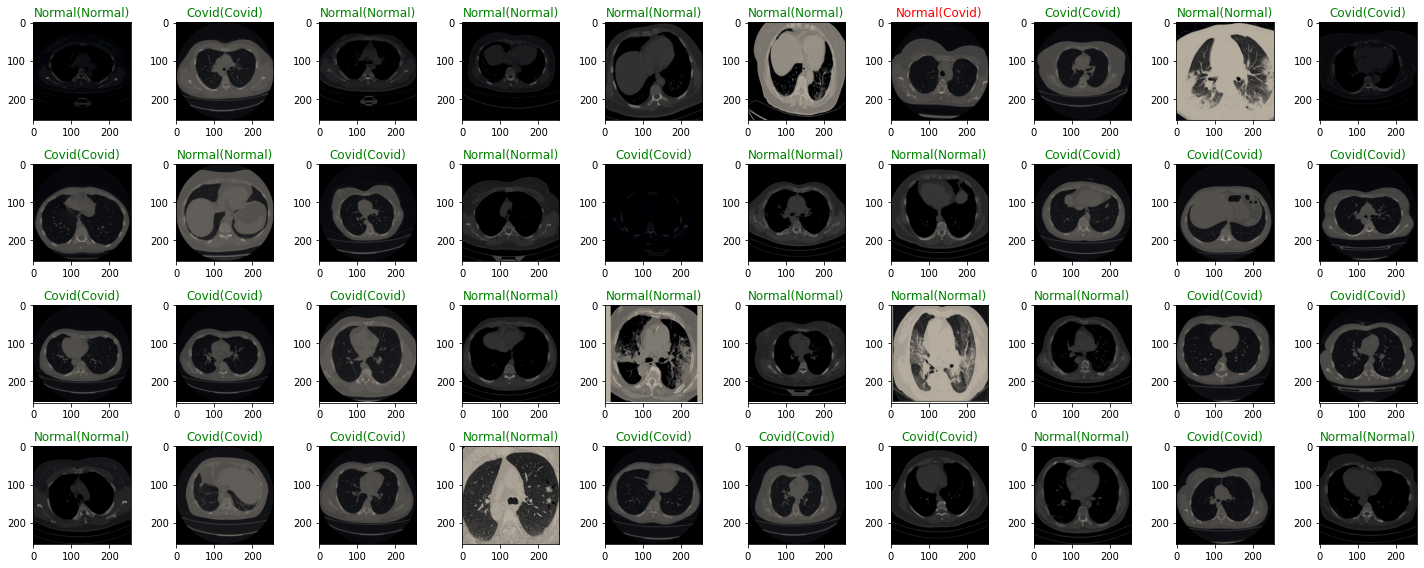

In [31]:
dataset_classes = ['Covid','Normal']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(dataset_classes[label])
   

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(validation_loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()